## Import libraries

In [1]:
!pip install pytorch-ignite
!pip install torcheval

In [2]:
COLAB = False

In [3]:
if COLAB:
    import sys
    import os
    from google.colab import drive

    # Mount Google Driveroo
    drive.mount('/content/drive')

    # Add the path to the Python module
    root_dir = '/content/drive/MyDrive/text_summarization'
    sys.path.append(os.path.join(root_dir, 'src'))
    sys.path.append(os.path.join(root_dir, 'src', 'utils'))
else:
    from pathlib import Path
    root_dir = Path.cwd().parent
root_dir

PosixPath('/home/jovyan/text_summarization')

In [4]:
import pandas as pd
import numpy as np
import os
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from utils.preprocessing import preprocessing_pipeline, get_data_distribution

In [6]:
from utils.processing import processing_pipeline

2025-05-29 13:06:49.955483: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-29 13:06:49.999821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-29 13:06:49.999847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-29 13:06:50.001184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-29 13:06:50.008765: I tensorflow/core/platform/cpu_feature_guar

In [7]:
# from train_model import main

In [8]:
PROCESSING = True
PREPROCESSING = False

In [9]:
name = "WikiHow"

In [10]:
raw_dir = os.path.join(root_dir, "raw_data", name)
dataset_dir = os.path.join(root_dir, "data", name)
figures_dir = os.path.join(root_dir, "figures", name)
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)

## Get the data

In [11]:
dataset_df = pd.read_csv(os.path.join(raw_dir, "wikihowSep.csv"))

In [12]:
csv_name = "wikihow_data"

## Preprocess the data

In [13]:
if PREPROCESSING:
    dataset_df = preprocessing_pipeline(dataset_df, stopwords, dataset_dir, csv_name, start_token = "SOS ", end_token = " EOS")

In [14]:
dataset_df = pd.read_csv(os.path.join(root_dir, "data", name, f'{csv_name}.csv'))
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251774 entries, 0 to 1251773
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   summary         1251774 non-null  object
 1   text            1251774 non-null  object
 2   length_summary  1251774 non-null  int64 
 3   length_text     1251774 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 38.2+ MB


In [15]:
dataset_df.head()

,summary,text,length_summary,length_text
0,SOS sell first EOS,SOS anything else stop sum artist think transl...,4,55
1,SOS take good pictures EOS,SOS like say pictures worth thousand words you...,5,75
2,SOS sure properly license art EOS,SOS licensing art way proving belongs necessar...,6,17
3,SOS expect gradual process dont expect sell lo...,SOS online art business needs built little lit...,11,68
4,SOS examine strengths performer EOS,SOS easy spend hours focused arent booking old...,5,26


## Get distribution of the data

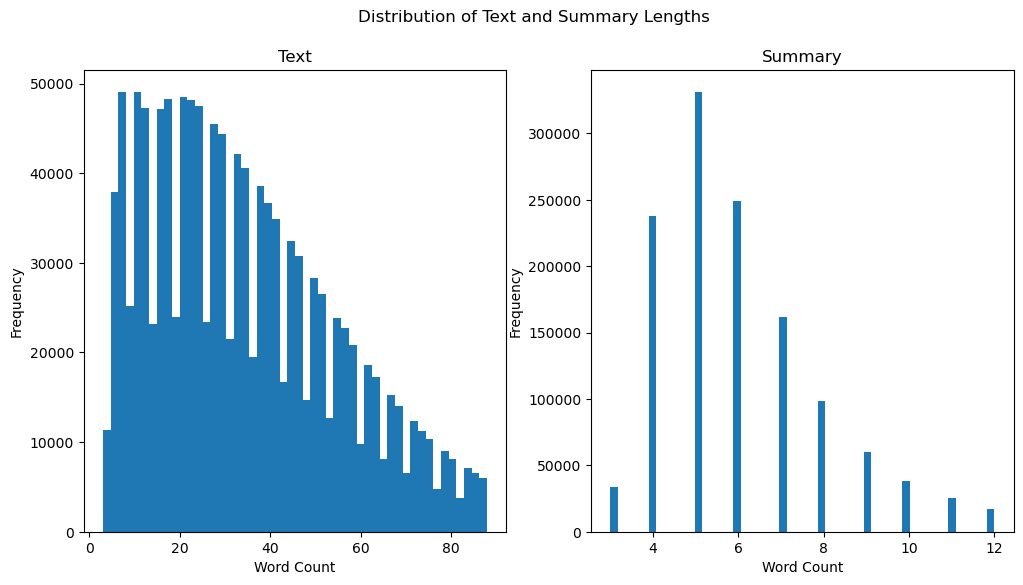

In [16]:
get_data_distribution(dataset_df, figures_dir, "wikihow")

## Process the datas

In [17]:
load_tokenizer = False
max_features = 15000

In [18]:
if PROCESSING:
    processing_pipeline(dataset_dir, csv_name, max_features = max_features, load_tokenizer = load_tokenizer)

Max length of text: 88
Max length of summary: 12
SOS index: 2
EOS index: 3
Number of Samples in X_train: 876241
Number of Samples in X_val: 225319
Number of Samples in X_test: 150214
Number of Samples in y_train: 876241
Number of Samples in y_val: 225319
Number of Samples in y_test: 150214
Saving x_train.pt...
Saving x_val.pt...
Saving x_test.pt...
Saving y_train.pt...
Saving y_val.pt...
Saving y_test.pt...


### Test the processing

In [19]:
test_decoding = True

In [20]:
if test_decoding:
    import torch
    import pickle
    import random
    
    def decode_data(text_ids, index2word, EOS_token):
        """
        Converts the text ids to words using the index2word mapping.
        """
        if text_ids.dim() > 1:
            text_ids = text_ids.view(-1)  # Flatten to 1D
    
        decoded_words = []
        for idx in text_ids:
            # Ensure idx is a scalar
            if isinstance(idx, torch.Tensor):
                idx = idx.item()
            if idx == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(index2word.get(idx, '<UNK>'))
    
        return decoded_words
    
    X_train = torch.load(os.path.join(dataset_dir, "x_train.pt"))
    y_train = torch.load(os.path.join(dataset_dir, "y_train.pt"))
    
    train_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size=1,
        shuffle=False,
    )
    with open(os.path.join(dataset_dir, 'feature_tokenizer.pickle'), 'rb') as handle:
            feature_tokenizer = pickle.load(handle)
    EOS_token = feature_tokenizer.word_index["EOS"]
    
    nb_decoding_test = 10
    count_test = 0
    random_list = random.sample(range(len(train_dataloader)), nb_decoding_test)
    for i, data in enumerate(train_dataloader):
        if i in random_list:
            input_tensor, target_tensor = data
            print('Input: {}'.format(decode_data(input_tensor[0], feature_tokenizer.index_word, EOS_token)))
            print('Target: {}'.format(decode_data(target_tensor[0], feature_tokenizer.index_word, EOS_token)))
            print('-----------------------------------')
            count_test += 1
        if count_test == nb_decoding_test:
            break

Input: ['SOS', 'cut', 'short', 'length', '<unk>', '<unk>', '<unk>', 'silver', 'wire', 'fit', '<unk>', 'hole', 'solder', 'bottom', 'wire', 'back', '<unk>', 'case', 'carefully', 'trim', 'wire', 'length', '<unk>', 'inch', '5', 'mm', 'inserting', 'hole', '<unk>', 'pliers', 'bottom', 'wire', 'must', 'touch', 'inside', 'dome', 'keep', 'pin', 'straight', 'carefully', 'solder', 'place', 'soft', 'flame', '<unk>', 'piece', 'water', 'check', 'strength', 'join', 'fingernail', '<EOS>']
Target: ['SOS', 'create', 'insert', '<unk>', 'pin', '<EOS>']
-----------------------------------
Input: ['SOS', '<unk>', 'period', 'specifies', 'quickly', 'years', 'cash', 'invested', 'particular', 'project', 'recovered', 'example', 'consider', 'project', 'requires', '100000', 'cash', '<unk>', 'immediately', 'expected', 'bring', 'additional', '10000', 'cash', 'year', '20', 'years', '<unk>', 'period', '10', 'years', '10', 'years', 'original', 'cash', '<unk>', 'recovered', '10000', '10', '100000', 'note', '<unk>', 'per

## Train the model

In [ ]:
import random

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.metrics import Rouge
from torcheval.metrics.functional import bleu_score
from tqdm import tqdm

from utils.models import AttnDecoderRNN, EncoderRNN
from utils.processing import processing_pipeline

plt.switch_backend('agg')
import argparse
import pickle
from pathlib import Path

import matplotlib.ticker as ticker
import numpy as np


def plot_losses(figures_dir, train_losses, val_losses):
    """
    Plots the training and validation losses.
    """
    fig = plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.savefig(os.path.join(figures_dir, 'losses.png'))
    plt.close(fig)

def evaluate_loss(dataloader, encoder, decoder, criterion):
    total_loss = 0
    batch_count = 0
    with torch.no_grad():
        for data in dataloader:
            batch_count += 1
            input_tensor, target_tensor = data

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
            )
            total_loss += loss.item()

            if batch_count == 50:
                return total_loss / batch_count

    return total_loss / len(dataloader)

def decode_data(text_ids, index2word, EOS_token):
    """
    Converts the text ids to words using the index2word mapping.
    """
    if text_ids.dim() > 1:
        text_ids = text_ids.view(-1)  # Flatten to 1D

    decoded_words = []
    for idx in text_ids:
        # Ensure idx is a scalar
        if isinstance(idx, torch.Tensor):
            idx = idx.item()
        if idx == EOS_token:
            decoded_words.append('EOS')
            break
        decoded_words.append(index2word.get(idx, '<UNK>'))

    return " ".join(decoded_words)

def make_predictions(encoder, decoder, input_tensor, target_tensor, index2word, EOS_token):
    """
    Computes the summary for the given input tensor and target tensor.
    """
    input_tensor = input_tensor[0].unsqueeze(0)
    target_tensor = target_tensor[0].unsqueeze(0)

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

    # Get the predicted words
    _, topi = decoder_outputs.topk(1)
    decoded_words = decode_data(topi.squeeze(), index2word, EOS_token)

    # Get the target words
    target_words = decode_data(target_tensor, index2word, EOS_token)

    return decoded_words, target_words

def compute_metrics(predictions, targets, n):
    """
    Computes the BLEU score and ROUGE score for the predictions and targets.
    """    
    metrics = {}
    rouge_metrics = Rouge(variants=["L", n], multiref="best")
    
    metrics["bleu"] = bleu_score(predictions, targets, n_gram=n)

    list_predictions = []
    list_targets = []
    for pred in predictions:
        list_predictions.append(pred.split())
    for target in targets:
        list_targets.append(target.split())

    rouge_metrics.update((list_predictions,  [list_targets]))
    metrics.update(rouge_metrics.compute())

    return metrics

def evaluate_model(encoder, decoder, dataloader, index2word, EOS_token):
    """
    Evaluates the model on the given dataloader.
    """
    encoder.eval()
    decoder.eval()

    predictions = []
    targets = []

    batch_count = 0
    with torch.no_grad():
        for data in dataloader:
            batch_count += 1
            input_tensor, target_tensor = data

            predicted_words, target_words = make_predictions(encoder, decoder, input_tensor, target_tensor, index2word, EOS_token)

            predictions.append(predicted_words)
            targets.append(target_words)

            if batch_count == 50:
                break

    return compute_metrics(predictions, targets, n=2)

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    encoder.train()
    decoder.train()

    print_every_batch = 100
    batch_count = 0
    total_loss = 0
    for data in tqdm(dataloader):
        batch_count += 1
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

        if batch_count % print_every_batch == 0:
          print("current loss", total_loss/batch_count)

        if batch_count == 50:
            return total_loss / batch_count

    return total_loss / len(dataloader)

def train(train_dataloader, val_dataloader, encoder, decoder, criterion,
          index2words, EOS_token, save_directory, figures_dir,
          n_epochs= 50, learning_rate=0.001, weight_decay=1e-5,
          print_every=100, plot_every=100, save_every=100, print_examples_every=5):

    # Initializations
    print('Initializing ...')
    plot_train_losses = []
    plot_val_losses = []
    print_train_loss_total = 0  # Reset every print_every
    plot_train_loss_total = 0  # Reset every plot_every
    print_val_loss_total = 0  # Reset every print_every
    plot_val_loss_total = 0  # Reset every plot_every
    best_val_loss = float('inf')

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop
    print("Training...")
    for epoch in range(1, n_epochs + 1):
        training_loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_train_loss_total += training_loss
        plot_train_loss_total += training_loss

        # Evaluate on validation set
        val_loss = evaluate_loss(val_dataloader, encoder, decoder, criterion)
        print_val_loss_total += val_loss
        plot_val_loss_total += val_loss

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
            }, os.path.join(save_directory, 'best_checkpoint.tar'))

        # Print progress
        if epoch % print_every == 0:
            print_train_loss_total = print_train_loss_total / print_every
            print_val_loss_total = print_val_loss_total / print_every
            print('epoch: {}; Average training loss: {:.4f}; Average validation loss: {:.4f}.'.format(
                    epoch, epoch / n_epochs * 100, print_train_loss_total, print_val_loss_total))

        if epoch % print_examples_every == 0:
            # Compute metrics for validation set
            val_metrics = evaluate_model(encoder, decoder, val_dataloader, index2words, EOS_token)
            print('BLEU score: {:.4f}'.format(val_metrics['bleu']))
            print('ROUGE-L score: {:.4f}'.format(val_metrics['Rouge-L-F']))
            print('ROUGE-2 score: {:.4f}'.format(val_metrics['Rouge-2-F']))
            print('-----------------------------------')
            print_train_loss_total = 0
            print_val_loss_total = 0
            # Get a random sample from the validation set
            index = random.randint(0, len(val_dataloader) - 1)
            for i, data in enumerate(val_dataloader):
                if i == index:
                    input_tensor, target_tensor = data
                    break
            decoded_words, target_words = make_predictions(encoder, decoder, input_tensor, target_tensor, index2words, EOS_token)
            print('Input: {}'.format(decode_data(input_tensor[0], feature_tokenizer.index_word, EOS_token)))
            print('Target: {}'.format(target_words))
            print('Predicted: {}'.format(decoded_words))
            print('-----------------------------------')

        # Plot loss progress
        if epoch % plot_every == 0:
            plot_loss_avg = plot_train_loss_total / plot_every
            plot_train_losses.append(plot_loss_avg)
            plot_val_loss_avg = plot_val_loss_total / plot_every
            plot_val_losses.append(plot_val_loss_avg)
            plot_train_loss_total = 0
            plot_val_loss_total = 0

    plot_losses(figures_dir, plot_train_losses, plot_val_losses)

def main(root_dir,
    load_checkpoint = False,     
    hidden_size = 128,
    name = "WikiHow",
    max_length = 50,
    lr = 0.001,
    weight_decay = 1e-4,
    batch_size = 32,
    num_workers = 4,
    n_epochs = 50,
    print_every = 10,
    plot_every = 10,
    save_every = 10,
    print_examples_every=5,
    ):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    # Random seed for reproducibility
    random.seed(5719)
    np.random.seed(5719)
    torch.manual_seed(5719)
    torch.use_deterministic_algorithms(False)

    # Get directories
    dataset_dir = os.path.join(root_dir, 'data', name)
    save_dir = os.path.join(root_dir, 'checkpoints', name)
    figures_dir = os.path.join(root_dir, 'figures', name)

    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(figures_dir, exist_ok=True)

    # Load the dataset
    X_train = torch.load(os.path.join(dataset_dir, "x_train.pt"))
    X_val = torch.load(os.path.join(dataset_dir, "x_val.pt"))
    X_test = torch.load(os.path.join(dataset_dir, "x_test.pt"))
    y_train = torch.load(os.path.join(dataset_dir, "y_train.pt"))
    y_val = torch.load(os.path.join(dataset_dir, "y_val.pt"))
    y_test = torch.load(os.path.join(dataset_dir, "y_test.pt"))    

    train_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True,
    )
    val_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_val, y_val),
        batch_size=batch_size,
        shuffle=True,
    )
    test_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_test, y_test),
        batch_size=batch_size,
        shuffle=True,
    )

    # Load the vocabulary
    with open(os.path.join(dataset_dir, 'feature_tokenizer.pickle'), 'rb') as handle:
            feature_tokenizer = pickle.load(handle)

    num_words_text = max(feature_tokenizer.word_index.values()) + 1
    EOS_token = feature_tokenizer.word_index["EOS"]

    # Initialize the model
    encoder = EncoderRNN(num_words_text, hidden_size).to(device)
    decoder = AttnDecoderRNN(hidden_size, num_words_text, max_length).to(device)
    criterion = nn.NLLLoss(ignore_index=0)

    if load_checkpoint:
      # Load the best model
      checkpoint = torch.load(os.path.join(save_dir, 'best_checkpoint.tar'))
      encoder.load_state_dict(checkpoint['encoder'])
      decoder.load_state_dict(checkpoint['decoder'])

    # Train the model
    train(train_dataloader, val_dataloader, encoder, decoder, criterion,
          feature_tokenizer.index_word, EOS_token, save_dir, figures_dir,
          learning_rate=lr, weight_decay=weight_decay, n_epochs=n_epochs,
          print_every=print_every, plot_every=plot_every, save_every=save_every, print_examples_every=print_examples_every)

    # Load the best model
    checkpoint = torch.load(os.path.join(save_dir, 'best_checkpoint.tar'))
    encoder.load_state_dict(checkpoint['en'])
    decoder.load_state_dict(checkpoint['de'])

    # Test the model
    test_loss = evaluate_loss(test_dataloader, encoder, decoder, criterion)
    print('Test loss: {:.4f}'.format(test_loss))

    # Evaluate the model
    metrics = evaluate_model(encoder, decoder, test_dataloader, feature_tokenizer.index_word, EOS_token)
    print('BLEU score: {:.4f}'.format(metrics['bleu']))
    print('ROUGE-L score: {:.4f}'.format(metrics['Rouge-L-F']))
    print('ROUGE-2 score: {:.4f}'.format(metrics['Rouge-2-F']))
    print('-----------------------------------')
    # Get a random sample from the test set
    index = random.randint(0, len(test_dataloader) - 1)
    for i, data in enumerate(test_dataloader):
        if i == index:
            input_tensor, target_tensor = data
            break
    decoded_words, target_words = make_predictions(encoder, decoder, input_tensor, target_tensor, feature_tokenizer.index_word, EOS_token)
    print('Input: {}'.format(decode_data(input_tensor[0], feature_tokenizer.index_word, EOS_token)))
    print('Target: {}'.format(target_words))
    print('Predicted: {}'.format(decoded_words))
    print('-----------------------------------')

/opt/conda/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [ ]:
hidden_size = 128
max_length = 50
lr = 0.001
weight_decay = 1e-4
batch_size = 64
num_workers = 16
n_epochs = 5
print_every = 1
plot_every = 1
save_every = 1
print_example_every = 1
load_checkpoint = False

In [23]:
main(
    root_dir = root_dir,
    load_checkpoint = load_checkpoint,
    hidden_size=hidden_size,
    name=name,
    max_length=max_length,
    lr=lr,
    weight_decay=weight_decay,
    batch_size=batch_size,
    num_workers=num_workers,
    n_epochs=n_epochs,
    print_every=print_every,
    plot_every=plot_every,
    save_every=save_every,
    print_examples_every=print_example_every)

cuda
Initializing ...
Training...


  0%|          | 49/27383 [00:06<56:37,  8.04it/s] 


epoch: 1; Average training loss: 2.0000; Average validation loss: 8.2633.
BLEU score: 0.0746
ROUGE-L score: 0.0000
ROUGE-2 score: 0.0000
-----------------------------------
Input: ['SOS', 'take', 'kissing', 'partners', 'bottom', 'lip', 'top', 'bottom', 'teeth', 'use', 'light', 'pressure', 'grab', 'lip', 'tug', 'bit', 'typically', 'aim', 'bottom', 'lip', 'experiment', '<unk>', 'upper', 'lip', 'well', 'light', 'bite', 'tug', 'bottom', 'lip', 'usually', 'considered', 'sensual', 'EOS']
Target: ['SOS', 'gently', 'grab', 'lip', 'teeth', 'EOS']
Predicted: ['SOS', '<unk>', '<unk>', 'EOS']
-----------------------------------


  0%|          | 49/27383 [00:05<53:42,  8.48it/s] 


epoch: 2; Average training loss: 4.0000; Average validation loss: 6.4050.
BLEU score: 0.0366
ROUGE-L score: 0.0000
ROUGE-2 score: 0.0000
-----------------------------------
Input: ['SOS', 'want', 'cat', 'use', 'cat', 'bed', 'instead', 'spending', 'day', '<unk>', 'furniture', 'place', 'bed', 'area', 'cat', 'already', 'likes', 'sleep', 'may', 'prompt', 'cat', 'use', 'bed', 'EOS']
Target: ['SOS', 'place', 'bed', 'cat', 'enjoys', 'sleeping', 'EOS']
Predicted: ['SOS', 'get', '<unk>', 'EOS']
-----------------------------------


  0%|          | 49/27383 [00:05<53:37,  8.49it/s] 


epoch: 3; Average training loss: 6.0000; Average validation loss: 6.1857.
BLEU score: 0.0626
ROUGE-L score: 0.0000
ROUGE-2 score: 0.0000
-----------------------------------
Input: ['SOS', 'lighthearted', 'speech', 'dont', 'afraid', 'crack', 'jokes', 'however', 'remember', 'keep', 'audience', 'mind', 'keep', 'clean', 'rule', 'wouldnt', 'tell', 'joke', 'grandmother', 'maybe', 'shouldnt', 'tell', 'speech', 'EOS']
Target: ['SOS', 'make', 'jokes', 'appropriate', 'EOS']
Predicted: ['SOS', 'make', '<unk>', 'EOS']
-----------------------------------


  0%|          | 49/27383 [00:05<53:49,  8.47it/s] 


epoch: 4; Average training loss: 8.0000; Average validation loss: 6.0909.
BLEU score: 0.0729
ROUGE-L score: 0.0000
ROUGE-2 score: 0.0000
-----------------------------------
Input: ['SOS', 'download', 'itunes', 'free', '<unk>', 'EOS']
Target: ['SOS', 'visit', 'itunes', 'website', 'EOS']
Predicted: ['SOS', 'get', '<unk>', 'EOS']
-----------------------------------


  0%|          | 49/27383 [00:05<53:37,  8.49it/s] 


epoch: 5; Average training loss: 10.0000; Average validation loss: 5.9272.
BLEU score: 0.0957
ROUGE-L score: 0.0000
ROUGE-2 score: 0.0000
-----------------------------------
Input: ['SOS', 'plug', 'value', 'equation', 'multiply', 'example', '<unk>', '<unk>', '<unk>', 'equation', 'look', 'like', '<unk>', '<unk>', 'get', '<unk>', '<unk>', 'EOS']
Target: ['SOS', 'use', 'calculator', 'find', '<unk>', 'angle', 'EOS']
Predicted: ['SOS', 'use', '<unk>', '<unk>', 'EOS']
-----------------------------------


  0%|          | 49/27383 [00:05<53:37,  8.49it/s] 


epoch: 6; Average training loss: 12.0000; Average validation loss: 5.9247.
BLEU score: 0.0773
ROUGE-L score: 0.0000
ROUGE-2 score: 0.0000
-----------------------------------
Input: ['SOS', '<unk>', 'formula', 'asks', 'three', 'sides', 'triangle', 'sides', 'stored', 'variables', 'abc', 'change', 'time', 'tell', 'calculator', 'order', 'would', 'need', 'use', 'prompt', 'command', 'hit', 'move', '<unk>', '<unk>', 'move', '<unk>', 'hit', 'takes', 'back', 'creating', 'screen', 'EOS']
Target: ['SOS', 'hopefully', 'know', 'formula', 'dont', 'look', 'EOS']
Predicted: ['SOS', 'make', '<unk>', 'EOS']
-----------------------------------


  0%|          | 49/27383 [00:05<53:39,  8.49it/s] 


epoch: 7; Average training loss: 14.0000; Average validation loss: 5.8663.
BLEU score: 0.0423
ROUGE-L score: 0.0000
ROUGE-2 score: 0.0000
-----------------------------------
Input: ['SOS', 'must', 'every', 'dog', 'puppy', 'make', 'sure', 'puppy', 'old', 'enough', 'take', 'medication', 'age', 'minimum', 'six', 'weeks', 'could', 'longer', 'make', 'sure', 'check', 'packaging', 'EOS']
Target: ['SOS', 'something', 'else', 'need', 'get', '<unk>', 'dog', 'soap', 'flea', 'collar', 'EOS']
Predicted: ['SOS', 'get', '<unk>', 'EOS']
-----------------------------------


  0%|          | 49/27383 [00:05<53:42,  8.48it/s] 


epoch: 8; Average training loss: 16.0000; Average validation loss: 5.8130.
BLEU score: 0.0348
ROUGE-L score: 0.0000
ROUGE-2 score: 0.0000
-----------------------------------
Input: ['SOS', 'party', 'done', 'tell', 'mom', 'youll', 'clean', 'encourage', 'whatever', 'wants', 'key', 'make', 'sure', 'end', 'day', 'relaxing', 'maybe', 'shell', 'cup', 'tea', 'talk', 'clean', 'maybe', 'shell', 'go', 'bath', 'sit', 'couch', 'watch', 'favorite', 'show', 'EOS']
Target: ['SOS', 'give', 'mom', 'quiet', 'time', 'end', 'night', 'EOS']
Predicted: ['SOS', 'get', 'EOS']
-----------------------------------


  0%|          | 49/27383 [00:05<53:42,  8.48it/s] 


KeyboardInterrupt: 